In [171]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.text import Text
from skimage import io
import pandas
import os
import sys
from textwrap import wrap
import math
import numpy as np

sys.path.insert(0, os.path.join(os.path.split(os.getcwd())[0], "classes"))
from Parameters import Parameters

In [412]:
def generate_average_intensity_plots(actin_kym, curvature_kym, curvature_threshold=0):
    """generate curves showing spatially-averaged actin intensity over time, and ratio of intensities above and below threshold curvature"""
    pos_curv_mask = np.ma.masked_greater(curvature_kym, curvature_threshold).mask;
    zero_intensity_mask = np.ma.masked_less_equal(actin_kym, curvature_threshold).mask;
    neg_curv_actin = np.ma.fix_invalid(actin_kym, 
                                       mask=np.bitwise_or(pos_curv_mask, zero_intensity_mask), 
                                       fill_value=None);
    pos_curv_actin = np.ma.fix_invalid(actin_kym, 
                                       mask=np.bitwise_or(np.bitwise_not(pos_curv_mask), zero_intensity_mask), 
                                       fill_value=None);
    all_actin = np.ma.fix_invalid(actin_kym, 
                                 mask=zero_intensity_mask, 
                                 fill_value=None);
    all_actin_I = all_actin.mean(0) - all_actin.min();
    all_actin_I = all_actin.mean(0) - all_actin.min();
    pos_curv_actin_I = pos_curv_actin.mean(0) - all_actin.min();
    neg_curv_actin_I = neg_curv_actin.mean(0) - all_actin.min();
    return all_actin_I, pos_curv_actin_I, neg_curv_actin_I;

def load_kymograph_data(experiment_folder):
    """load curvature and intensity kymographs, along with image parameters"""
    actin_kyms = []; 
    curvature_kyms = [];
    paramses = [];
    subtitles = [];
    
    for idx, subfolder in enumerate(os.listdir(experiment_folder)):
        actin_kyms.append(io.imread(os.path.join(experiment_folder, subfolder, "normalised position Actin kymograph.tif")));
        curvature_kyms.append(io.imread(os.path.join(experiment_folder, subfolder, "normalised position curvature kymograph.tif")));
        params = Parameters();
        params.loadParametersFromJson(os.path.join(experiment_folder, subfolder, "parameters used.json"));
        paramses.append(params);
        if condition_names is None:
            if use_subfolder_as_condition:
                subtitles.append(subfolder)
            else:
                subtitles.append(os.path.splitext(os.path.basename(params.input_image_path))[0]);
        else:
            subtitles.append(condition_names[idx]);

    return actin_kyms, curvature_kyms, paramses, subtitles;
    
def curvature_with_intensity_alpha(curv_im, actin_im):
    """from imshow results, return an rgba image of curvature with actin intensity controlling the alpha channel"""
    curv_range = curv_im.get_clim();
    i_range = actin_im.get_clim();

    norm_curv = (np.round(255*(curvature_kym - min(curv_range))/(max(curv_range) - min(curv_range)))).astype(int);
    norm_i = (actin_kym - min(i_range))/(max(i_range) - min(i_range));
    norm_curv = np.clip(norm_curv, 0, 255);
    norm_i = np.clip(norm_i, 0, 1);

    # horrible for-loop - better with numpy?:
    merged_im = np.zeros((norm_curv.shape[0], norm_curv.shape[1], 4));
    for xidx in range(norm_curv.shape[0]):
        for yidx in range(norm_curv.shape[1]):
            val = norm_curv[xidx, yidx];
            mapped_val = plt.cm.jet(val);
            merged_im[xidx, yidx, 0] = mapped_val[0];
            merged_im[xidx, yidx, 1] = mapped_val[1];
            merged_im[xidx, yidx, 2] = mapped_val[2];
            merged_im[xidx, yidx, 3] = norm_i[xidx, yidx];
    
    return merged_im;

## Montage kymographs

#### Usage
* Make a new folder with the experiment (or comparison) title as its name. 
* Put the (dated) output folders from analyses of interest into the experiment folder
* Write the path to the folder in the "experiment folder" variable immediately below, taking care to use \\\ to separate folders
* Figure sub-titles are taken from the original data path by default - to override these, change the "condition_names" variable from None to a list of names, e.g. \["control", "condition 1", "condition 2"\]
* Arrows can be added to the plot by changing the "annotation_arrows" variable from None to a list of tuples, each of which should contain the index (starting from zero) for the figure column to annotate, and a tuple to position the head of the arrow in coordinates of fractional position in the axes
* Output figures can be saved by right clicking on the figure and saving as a PNG to the local machine

C:\Users\dougk\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2128: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


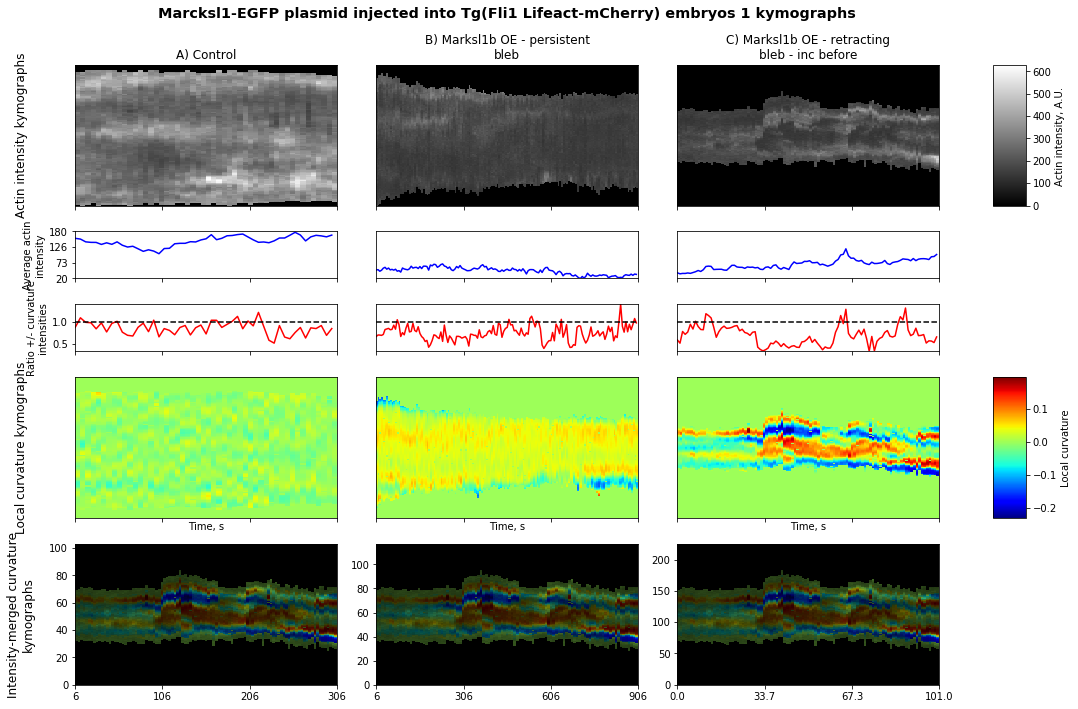

In [417]:
#experiment_folder = "D:\\data\\Inverse blebbing\\Experiment 1";
experiment_folder = "D:\\analysis\\2018-12-28 Images for LKP presentation\\Marcksl1-EGFP plasmid injected into Tg(Fli1 Lifeact-mCherry) embryos 1";
condition_names = None;
#condition_names = ["control", "condition 1", "condition 2"]
annotation_arrows = None;
#annotation_arrows = [(0, (0.1, 0.66)), (2, (0.66, 0.45))];
use_subfolder_as_condition = True;
curvature_threshold = 0.05;

# load and plot kymographs
actin_kyms, curvature_kyms, paramses, subtitles = load_kymograph_data(experiment_folder);

average_nonzero_intensities = [];
intensity_ratios = [];
title_text_objs = [];
experiment_title = os.path.basename(experiment_folder);

curv_lims = (min([im.min() for im in curvature_kyms]), max([im.max() for im in curvature_kyms]));
intensity_lims = (min([im.min() for im in actin_kyms]), max([im.max() for im in actin_kyms]));
fig, axs = plt.subplots(ncols=len(actin_kyms), 
                        nrows=5, 
                        sharex='col',
                        figsize=(3*len(curvature_kyms),10), 
                        gridspec_kw = {'height_ratios':[3, 1, 1, 3, 3]});
for idx in range(len(actin_kyms)):
    t_offs = 0;
    timestep = paramses[idx].frame_interval;
    if paramses[idx].time_crop_start_end is not None:
        t_offs = float(paramses[idx].time_crop_start_end[0] * paramses[idx].frame_interval);
    actin_im=axs[0][idx].imshow(actin_kyms[idx], 
                           plt.cm.gray, 
                           vmin=intensity_lims[0], 
                           vmax=intensity_lims[1],
                           aspect='auto', 
                           interpolation=None, 
                           extent=[t_offs,timestep*actin_kyms[idx].shape[1]+t_offs,0,actin_kyms[idx].shape[0]]);
    average_nonzero_intensity, avg_nzi_pos_curv, avg_nzi_neg_curv = generate_average_intensity_plots(actin_kyms[idx], curvature_kyms[idx], curvature_threshold=0);
    average_nonzero_intensities.append(average_nonzero_intensity);
    t = [t_offs + tidx*timestep for tidx in range(actin_kyms[idx].shape[1])];
    avgIplt = axs[1][idx].plot(t, average_nonzero_intensity, 'b-')
    intensity_ratios.append(avg_nzi_pos_curv/avg_nzi_neg_curv);
    ratioIplt = axs[2][idx].plot(t, avg_nzi_pos_curv/avg_nzi_neg_curv, 'r-',
                                t, np.ones_like(t), 'k--')
    curv_im=axs[3][idx].imshow(curvature_kyms[idx], 
                           plt.cm.jet, 
                           vmin=curv_lims[0], 
                           vmax=curv_lims[1], 
                           aspect='auto', 
                           interpolation=None, 
                           extent=[t_offs,timestep*actin_kyms[idx].shape[1]+t_offs,0,actin_kyms[idx].shape[0]]);
    axs[3][idx].set_xlabel("Time, " + paramses[idx].interval_unit);
    axs[0][idx].set_yticks([]);
    axs[3][idx].set_yticks([]);
    n_x_ticks = 4;
    merged_im = curvature_with_intensity_alpha(curv_im, actin_im);
    axs[4][idx].set_facecolor('k');
    axs[4][idx].imshow(merged_im, 
                  aspect='auto', 
                  interpolation=None, 
                  extent=[t_offs,timestep*actin_kyms[idx].shape[1]+t_offs,0,actin_kyms[idx].shape[0]])
    axs[4][idx].set_xticks([t_offs + (xidx*timestep*actin_kyms[idx].shape[1])/(n_x_ticks-1) for xidx in range(n_x_ticks)])

# handle presentation
plt.tight_layout()
fig.subplots_adjust(top=0.90, right=0.9, left=0.1);
cbar_ax1 = fig.add_axes([0.95, axs[0][len(actin_kyms)-1].get_position().y0, 
                         0.03, (axs[0][len(actin_kyms)-1].get_position().y1 - axs[0][len(actin_kyms)-1].get_position().y0)])
cbar_ax2 = fig.add_axes([0.95, axs[3][len(actin_kyms)-1].get_position().y0, 
                         0.03, (axs[3][len(actin_kyms)-1].get_position().y1 - axs[3][len(actin_kyms)-1].get_position().y0)])
fig.colorbar(actin_im, cax=cbar_ax1);
fig.colorbar(curv_im, cax=cbar_ax2);
cbar_ax1.set_ylabel(paramses[0].labeled_species + " intensity, A.U. ");
cbar_ax2.set_ylabel("Local curvature");

avgd_intensity_lims = [10*np.floor(np.min([i.min() for i in average_nonzero_intensities])/10), 
                       10*np.ceil(max([i.max() for i in average_nonzero_intensities])/10)];
ratio_lims = [np.min([r.min() for r in intensity_ratios]), 
              max([r.max() for r in intensity_ratios])];

for idx in range(len(actin_kyms)):
    title_text_objs.append(axs[0][idx].set_title("\n".join(wrap(subtitles[idx], 30))));
    axs[1][idx].set_ylim(avgd_intensity_lims);
    axs[2][idx].set_ylim(ratio_lims);
    n_y_ticks = 4;
    axs[1][idx].set_yticks([int(avgd_intensity_lims[0] + yidx*(avgd_intensity_lims[1] - avgd_intensity_lims[0])/(n_y_ticks-1)) 
                        for yidx in range(n_y_ticks)]);
    #axs[2][idx].set_yticks([int(ratio_lims[0] + yidx*(ratio_lims[1] - ratio_lims[0])/(n_y_ticks-1)) 
    #                    for yidx in range(n_y_ticks)]);
    if idx!=0:
        axs[1][idx].set_yticks([]);
        axs[2][idx].set_yticks([]);
        axs[1][idx].set_ylim(avgd_intensity_lims);
        axs[2][idx].set_ylim(ratio_lims);

# subtitles = ['Actin intensity kymograph', 'Average actin intensity', '', 'Local curvature kymograph'];
# for row_idx in range(4):
#     if (row_idx==0) or (row_idx==3):
#         bbox = axs[row_idx][0].get_position();
#         ypos = 0.5*(bbox.ymin + bbox.ymax);
#     else:
#         bbox = axs[row_idx][0].get_position();
#         bbox2 = axs[row_idx+1][0].get_position();
#         ypos = 0.5*(bbox2.ymin + bbox.ymax)
#     txt = Text(0.05, ypos, "\n".join(wrap(subtitles[row_idx], 30)), 
#                    rotation='vertical', 
#                    horizontalalignment='center', 
#                    va='center', 
#                   fontsize=title_text_objs[idx].get_fontsize());
#     fig.add_artist(txt) 
    
subtitles = ['Actin intensity kymographs', 
             'Average actin intensity', 
             'Ratio +/- curvature intensities', 
             'Local curvature kymographs', 
             'Intensity-merged curvature kymographs'];
for row_idx in range(5):
    txt = None;
    if (row_idx==0) or (row_idx==3) or (row_idx==4):
        bbox = axs[row_idx][0].get_position();
        ypos = 0.5*(bbox.ymin + bbox.ymax);
        txt = Text(0.05, ypos, "\n".join(wrap(subtitles[row_idx], 30)), 
                   rotation='vertical', 
                   horizontalalignment='center', 
                   va='center', 
                  fontsize=title_text_objs[idx].get_fontsize());
    else:
        axs[row_idx][0].set_ylabel("\n".join(wrap(subtitles[row_idx], 20)))
    
    if txt is not None:
        fig.add_artist(txt) 

plt.rc('figure', titlesize='x-large', titleweight='bold')
fig.suptitle(experiment_title + " kymographs");
if annotation_arrows is not None:
    for ann in annotation_arrows:
        direction = -1 if ann[1][1] > 0.5 else 1;
        axs[0][ann[0]].annotate('', xycoords='axes fraction', xy=ann[1], 
                                xytext=(ann[1][0], ann[1][1] - direction * 0.1), textcoords='axes fraction',
                                arrowprops=dict(facecolor='black', edgecolor='white'));
        axs[3][ann[0]].annotate('', xycoords='axes fraction', xy=ann[1], 
                                xytext=(ann[1][0], ann[1][1] - direction * 0.1), textcoords='axes fraction',
                                arrowprops=dict(facecolor='black', edgecolor='white'));
        
plt.show();

## Montage curvature overlays

#### Usage
* Set up experiment folder as outlined above
* Write the path to the folder in the "experiment folder" variable immediately below, taking care to use \\ to separate folders
* Write the time points to display in the chosen_timepoints list immediately below. If the chosen time points don't exist in for the data, the closest possible time point will be used instead. If the chosen time point lies outside the range of data time points, the pane in the figure is left blank
* As above, figure sub-titles are taken from the original data path by default - to override these, change the "condition_names" variable from None to a list of names, e.g. \["control", "condition 1", "condition 2"\]
* Output figures can be saved by right clicking on the figure and saving as a PNG to the local machine

C:\Users\dougk\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2128: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


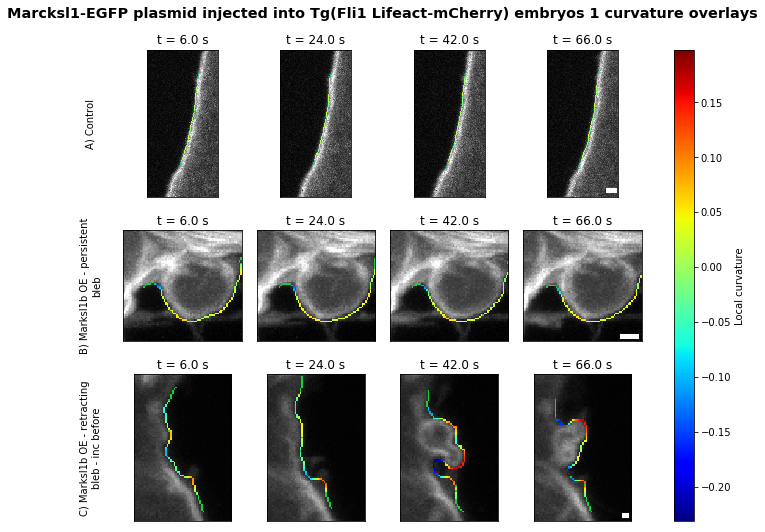

In [83]:
#experiment_folder = "D:\\data\\Inverse blebbing\\Experiment 1";
experiment_folder = "D:\\analysis\\2018-12-28 Images for LKP presentation\\Marcksl1-EGFP plasmid injected into Tg(Fli1 Lifeact-mCherry) embryos 1";
chosen_timepoints = [6, 24, 42, 66];
condition_names = None;
#condition_names = ["control", "condition 1", "condition 2"];
scale_bar_size_um = 1.0;
scale_bar_position = (0.75, 0.9) # in normalised axis coordinates
scale_bar_color = 'w';
use_subfolder_as_condition = True;

ims = [];
raw_curvatures = [];
paramses = [];
subtitles = [];
# load and plot images
experiment_title = os.path.basename(experiment_folder);
for idx, subfolder in enumerate(os.listdir(experiment_folder)):
    ims.append(io.imread(os.path.join(experiment_folder, subfolder, "overlaid curvature.tif")));
    raw_curvatures.append(io.imread(os.path.join(experiment_folder, subfolder, "raw curvature.tif")));
    params = Parameters();
    params.loadParametersFromJson(os.path.join(experiment_folder, subfolder, "parameters used.json"));
    paramses.append(params);
    if condition_names is None:
        if use_subfolder_as_condition:
            subtitles.append(subfolder)
        else:
            subtitles.append(os.path.splitext(os.path.basename(params.input_image_path))[0]);
    else:
        subtitles.append(condition_names[idx]);

curv_lims =  (min([raw_cs.min() for raw_cs in raw_curvatures]), max([raw_cs.max() for raw_cs in raw_curvatures]))
fig, axs = plt.subplots(ncols=len(chosen_timepoints), nrows=len(ims), figsize=(3*len(ims),2.5*len(ims)));
for imidx in range(len(ims)):
    t_offs = 0;
    if paramses[imidx].time_crop_start_end is not None:
        t_offs = float(paramses[imidx].time_crop_start_end[0]) * paramses[imidx].frame_interval;
    chosen_frames = [round((t - t_offs)/ paramses[imidx].frame_interval) for t in chosen_timepoints];
    closest_timepoints = [fr * paramses[imidx].frame_interval + t_offs for fr in chosen_frames];
    chosen_frames = [ch if ((ch < ims[imidx].shape[0]) and (ch >= 0)) else float('nan') for ch in chosen_frames];
    for fridx, fr in enumerate(chosen_frames):
        cbw = math.ceil(0.95 * ims[imidx][0].shape[1]);
        if not math.isnan(fr):
            curv_pix = np.nonzero(raw_curvatures[imidx][fr]);
            for pixx, pixy in zip(curv_pix[0], curv_pix[1]):
                curv = raw_curvatures[imidx][fr][pixx][pixy];
                existing_val = ims[imidx][fr][pixx][pixy];
                curv_idx_8bit = int(round(255 * (curv - curv_lims[0]) / (curv_lims[1] - curv_lims[0])));
                r, g, b, _ = cm.jet(curv_idx_8bit);
                ims[imidx][fr][pixx][pixy][0] = int(round(255*r));
                ims[imidx][fr][pixx][pixy][1] = int(round(255*g));
                ims[imidx][fr][pixx][pixy][2] = int(round(255*b));
            axs[imidx][fridx].imshow(ims[imidx][fr][:, :cbw, :]);
            axs[imidx][fridx].set_title("t = " + str(closest_timepoints[fridx]) + " s");
        else:
            axs[imidx][fridx].imshow(ims[imidx][0][:, :cbw, :], alpha=0);
            axs[imidx][fridx].set_frame_on(False);
            axs[imidx][fridx].set_visible(False);
        axs[imidx][fridx].set_xticks([]);
        axs[imidx][fridx].set_yticks([]);
        #if fridx == 0:
        #    axs[imidx][fridx].set_ylabel("\n".join(wrap(subtitles[imidx], 30)));
        if fridx == chosen_frames.index(max([f for f in chosen_frames if not np.isnan(f)])):
            scalebar_len_pix = round(float(scale_bar_size_um) / paramses[imidx].pixel_physical_size);
            axis_height_pt = axs[imidx][fridx].get_window_extent().transformed(fig.dpi_scale_trans.inverted()).height*fig.dpi;
            sb_xdata=[0.9 * ims[imidx][0].shape[1] - scalebar_len_pix, 0.9 * ims[imidx][0].shape[1]];
            sb_ydata=[0.95 * ims[imidx][0].shape[0], 0.95 * ims[imidx][0].shape[0]]; 
            scalebar = Line2D(color=scale_bar_color, 
                              xdata=sb_xdata, 
                              ydata=sb_ydata,
                             linewidth=axis_height_pt/25);
            axs[imidx][fridx].add_artist(scalebar);
plt.tight_layout();
fig.subplots_adjust(top=0.9, right=0.9, hspace=0.1, left=0.1);
cmap = plt.get_cmap('jet');
norm = colors.Normalize(vmin=curv_lims[0],vmax=curv_lims[1]);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm);
sm.set_array([]);
cbar_ax1 = fig.add_axes([0.95, axs[len(ims)-1][len(chosen_timepoints)-1].get_position().y0, 0.03, (axs[0][len(chosen_timepoints)-1].get_position().y1 - axs[len(ims)-1][len(chosen_timepoints)-1].get_position().y0)])
fig.colorbar(sm, cax=cbar_ax1);
cbar_ax1.set_ylabel("Local curvature");
plt.rc('figure', titlesize='x-large', titleweight='bold');
fig.suptitle(experiment_title + " curvature overlays");
for imidx in range(len(ims)):
    bbox = axs[imidx][0].get_position();
    txt = Text(0.05, 0.5*(bbox.ymin + bbox.ymax), "\n".join(wrap(subtitles[imidx], 30)), rotation='vertical', horizontalalignment='center', va='center');
    fig.add_artist(txt)

neg curves, max actin intensity = 531.52527, min actin intensity = 127.68787
pos curves, max actin intensity = 488.40195, min actin intensity = 125.358955
pos curv mean actin intensity = 173.55459718208093, neg curve mean actin intensity = 201.642174686678


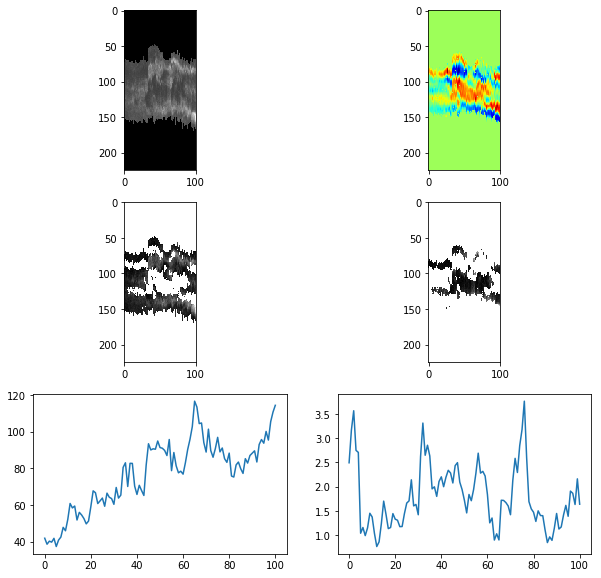

In [333]:
fig, axs = plt.subplots(3,2, figsize=(10,10));
axs[0][0].imshow(actin_kyms[2], plt.cm.gray);
thresh_val = 0.025
axs[0][1].imshow(curvature_kyms[2], plt.cm.jet);
pos_curv_mask = np.ma.masked_greater(curvature_kyms[2], thresh_val).mask;
zero_intensity_mask = np.ma.masked_less_equal(actin_kyms[2], thresh_val).mask;
neg_curv_actin = np.ma.fix_invalid(actin_kyms[2], 
                                   mask=np.bitwise_or(pos_curv_mask, zero_intensity_mask), 
                                   fill_value=None);
pos_curv_actin = np.ma.fix_invalid(actin_kyms[2], 
                                   mask=np.bitwise_or(np.bitwise_not(pos_curv_mask), zero_intensity_mask), 
                                   fill_value=None);
axs[1][0].imshow(neg_curv_actin, plt.cm.gray)
print("neg curves, max actin intensity = " + str(neg_curv_actin.max()) + ", min actin intensity = " + str(neg_curv_actin.min()))
print("pos curves, max actin intensity = " + str(pos_curv_actin.max()) + ", min actin intensity = " + str(pos_curv_actin.min()))
print("pos curv mean actin intensity = " + str(pos_curv_actin.mean()) + ", neg curve mean actin intensity = " + str(neg_curv_actin.mean()));
axs[1][1].imshow(pos_curv_actin, plt.cm.gray);
offset = min([neg_curv_actin.min(), pos_curv_actin.min()])
ratio = (neg_curv_actin.mean(0)-offset)/(pos_curv_actin.mean(0)-offset)
axs[2][0].plot(neg_curv_actin.mean(0)-min([neg_curv_actin.min(), pos_curv_actin.min()]));
axs[2][1].plot(ratio);
plt.show()

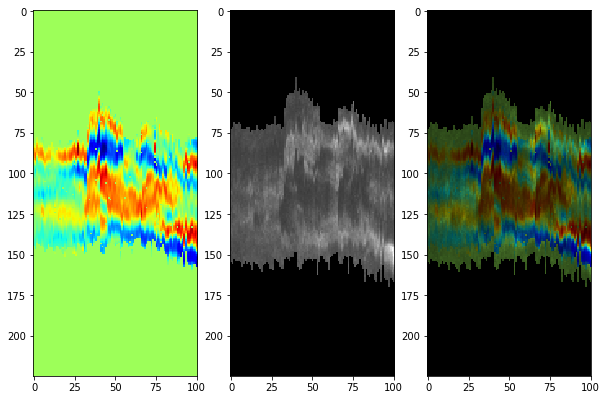

In [411]:
curvature_kym = curvature_kyms[2];
actin_kym = actin_kyms[2];
fig, axs = plt.subplots(1,3, figsize=(10,10));
curv_im = axs[0].imshow(curvature_kym, plt.cm.jet)
actin_im = axs[1].imshow(actin_kym, plt.cm.gray)
axs[2].set_facecolor('k');
curv_range = curv_im.get_clim();
i_range = actin_im.get_clim();

norm_curv = (np.round(255*(curvature_kym - min(curv_range))/(max(curv_range) - min(curv_range)))).astype(int);
norm_i = (actin_kym - min(i_range))/(max(i_range) - min(i_range));
norm_curv = np.clip(norm_curv, 0, 255);
norm_i = np.clip(norm_i, 0, 1);


# horrible for-loop - better with numpy?:
merged_im = np.zeros((norm_curv.shape[0], norm_curv.shape[1], 4));
for xidx in range(norm_curv.shape[0]):
    for yidx in range(norm_curv.shape[1]):
        val = norm_curv[xidx, yidx];
        mapped_val = plt.cm.jet(val);
        merged_im[xidx, yidx, 0] = mapped_val[0];
        merged_im[xidx, yidx, 1] = mapped_val[1];
        merged_im[xidx, yidx, 2] = mapped_val[2];
        merged_im[xidx, yidx, 3] = norm_i[xidx, yidx];
axs[2].imshow(merged_im);
plt.show();